In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set some formatting options for pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
# The starting point is to use our dataset where we have clear room 
# following the financial statements for an approximate one year holding period return (200+ trading days)
df = pd.read_csv(r'dataset\y_pred.csv', sep='|')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4678 entries, 0 to 4677
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_isin               4678 non-null   object 
 1   date                     4678 non-null   object 
 2   financial_year_end       4678 non-null   object 
 3   one_year_holding_return  4678 non-null   float64
 4   trading_days             4678 non-null   int64  
 5   return_calc_start_date   4678 non-null   object 
 6   return_calc_end_date     4678 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 256.0+ KB


In [3]:
# Import all required raw data files, I will ignore earnings and stock info from euronext now
# To make things easier, my index will always we a combination of stock_isin and date
balance_sheet_yahoo = pd.read_csv(r'raw_data\balance_sheet_yahoo.csv', sep='|')
cashflow_yahoo = pd.read_csv(r'raw_data\cashflow_yahoo.csv', sep='|')
financials_yahoo = pd.read_csv(r'raw_data\financials_yahoo.csv', sep='|')
price_yahoo = pd.read_csv(r'raw_data\price_yahoo.csv', sep='|')
stock_info_yahoo = pd.read_csv(
    r'raw_data\stock_info_yahoo.csv', sep='|')
stock_info_euronext = pd.read_csv(
    r'raw_data\stock_info_euronext.csv', sep='|')


In [4]:
# Pivot all datasets for joining
balance_sheet_yahoo_pivot = balance_sheet_yahoo.pivot(
    index=['date', 'stock_isin'], columns='balance_sheet_measure', values='amount')
financials_yahoo_pivot = financials_yahoo.pivot(
    index=['date', 'stock_isin'], columns='financial_statement_measure', values='amount')
cashflow_yahoo_pivot = cashflow_yahoo.pivot(
    index=['date', 'stock_isin'], columns='cash_flow_measure', values='amount')


In [5]:
# Create a GIANT dataframe with all financial information
df_add_balance_sheet = pd.merge(df, balance_sheet_yahoo_pivot, how='inner', 
    left_on=['stock_isin', 'date'], right_on=['stock_isin', 'date'])
df_add_financials = pd.merge(df_add_balance_sheet, financials_yahoo_pivot, how='inner', 
    left_on=['stock_isin', 'date'], right_on=['stock_isin', 'date'])
df_add_cash_flow = pd.merge(df_add_financials, cashflow_yahoo_pivot, how='inner',
    left_on=['stock_isin', 'date'], right_on=['stock_isin', 'date'])
# Add some industry information in becuase I think it will be interesting
df = pd.merge(df_add_cash_flow, stock_info_yahoo, how='inner',
              left_on=['stock_isin'], right_on=['stock_isin'])
df = pd.merge(df, stock_info_euronext, how='inner',
              left_on=['stock_isin'], right_on=['stock_isin'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4612 entries, 0 to 4611
Data columns (total 89 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   stock_isin                                 4612 non-null   object 
 1   date                                       4612 non-null   object 
 2   financial_year_end                         4612 non-null   object 
 3   one_year_holding_return                    4612 non-null   float64
 4   trading_days                               4612 non-null   int64  
 5   return_calc_start_date                     4612 non-null   object 
 6   return_calc_end_date                       4612 non-null   object 
 7   Accounts Payable                           4512 non-null   float64
 8   Capital Surplus                            3698 non-null   float64
 9   Cash                                       4558 non-null   float64
 10  Common Stock            

<AxesSubplot:xlabel='feature_current_ratio'>

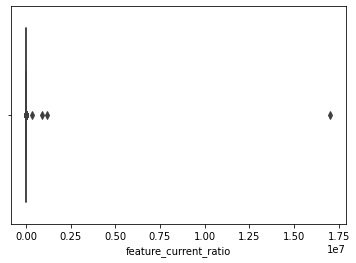

In [6]:
# All the above info is not really interpretable as is, we need to convert it to financial ratios
# I wanted 10 ratios in total so I just picked a few I could calculate. 
# I want to limit my dataset to 10 key financial metrics
# 1. Quick Ratio = Current Assets / Current Liabilities
df['feature_current_ratio'] = df['Total Current Assets'] /df['Total Current Liabilities']
sns.boxplot(x = df['feature_current_ratio'])

<AxesSubplot:xlabel='feature_return_on_equity'>

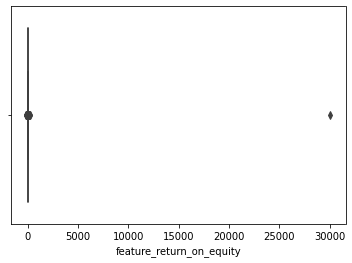

In [7]:
# 2. Return On Equity = (Earnings – Dividends) / Shareholders Equity
df['feature_return_on_equity'] = (df['Net Income_x'] -
                                  np.nan_to_num(df['Dividends Paid']))/df['Total Stockholder Equity']
sns.boxplot(x=df['feature_return_on_equity'])

<AxesSubplot:xlabel='feature_debt_to_equity_ratio'>

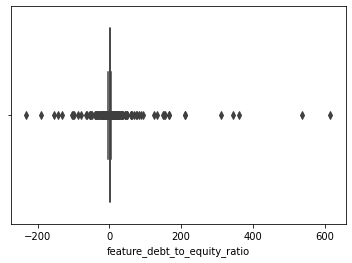

In [8]:
# 3. Debt to equity ratio = Total Liabilities / Shareholders Equity
df['feature_debt_to_equity_ratio'] = df['Total Liab']/df['Total Stockholder Equity']
sns.boxplot(x = df['feature_debt_to_equity_ratio'])


<AxesSubplot:xlabel='feature_operating_cash_flow_ratio'>

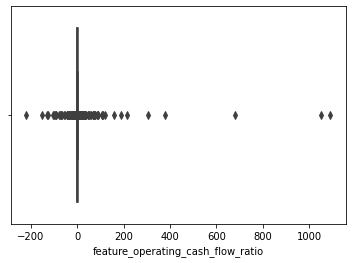

In [9]:
# 4. Operating Cash Flow Ratio = Cash Flow from Operations /Sales
df['feature_operating_cash_flow_ratio'] = df['Total Cash From Operating Activities'] / \
    df['Operating Income']
sns.boxplot(x=df['feature_operating_cash_flow_ratio'])


<AxesSubplot:xlabel='feature_interest_coverage_ratio'>

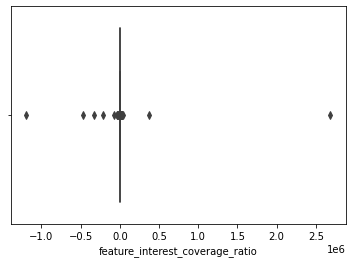

In [10]:
# 5. Interest coverage ratio = EBIT / Interest expense
df['feature_interest_coverage_ratio'] = df['Ebit'] / df['Interest Expense']
sns.boxplot(x=df['feature_interest_coverage_ratio'])


<AxesSubplot:xlabel='feature_ebit_to_total_assets'>

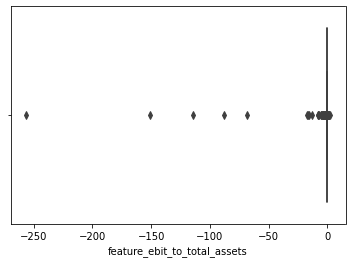

In [11]:
# 6. EBIT to Total Assets = Earnings Before Interest and Taxes / Total Assets
df['feature_ebit_to_total_assets'] = df['Ebit'] / df['Total Assets']
sns.boxplot(x=df['feature_ebit_to_total_assets'])


<AxesSubplot:xlabel='feature_free_cash_flow_ratio'>

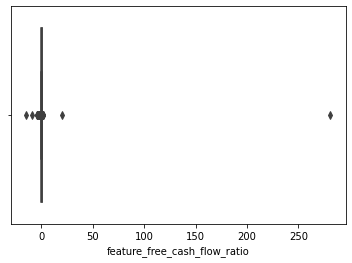

In [12]:
# 7. Cash flow Ratio = Free cash flow/ Total Assets
# Free cash flow =  operating cash flow – capital expenditures
df['free_cash_flow'] = df['Total Cash From Operating Activities'] - np.nan_to_num(df['Capital Expenditures'])
df['feature_free_cash_flow_ratio'] = df['free_cash_flow'] / df['Total Assets']
sns.boxplot(x=df['feature_free_cash_flow_ratio'])


<AxesSubplot:xlabel='feature_price_to_earnings_ratio'>

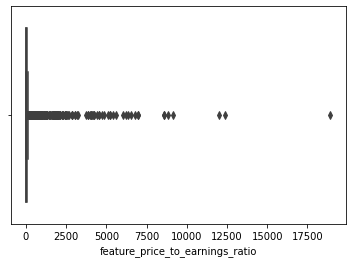

In [13]:
# 8. PE ratio (well a variation at least)
df['feature_price_to_earnings_ratio'] = df['Total Revenue'] / df['Common Stock']
sns.boxplot(x=df['feature_price_to_earnings_ratio'])


<AxesSubplot:xlabel='feature_payables_to_receivables_ratio'>

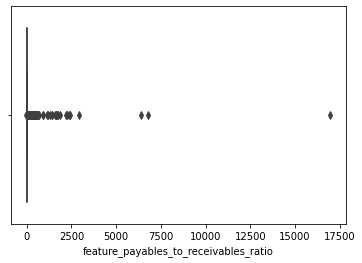

In [14]:
# 9. AR/AP Ratio
df['feature_payables_to_receivables_ratio'] = df['Accounts Payable'] / df['Net Receivables']
sns.boxplot(x=df['feature_payables_to_receivables_ratio'])


<AxesSubplot:xlabel='feature_debt_ratio'>

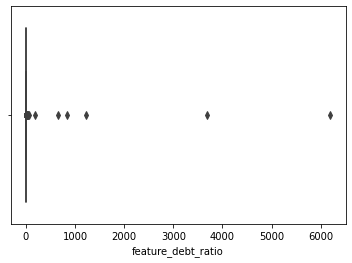

In [15]:
# 10. Debt Ratio
df['feature_debt_ratio'] = df['Total Liab'] / df['Total Assets']
sns.boxplot(x=df['feature_debt_ratio'])

In [16]:
# Save to full file to csv 
df.to_csv(
    'dataset/full_dataset.csv', sep='|', index=False)


In [17]:
# Save just my feature with predictors set
# df.to_csv('dataset/full_dataset.csv', sep='|', index=False)
feature_columns = list(df.filter(like='feature_').columns)
columns = feature_columns + ['financial_year_end', 'one_year_holding_return', 'stock_isin']
machine_learning_dataset = df[columns]

In [18]:
machine_learning_dataset.to_csv(
    'dataset/machine_learning_dataset.csv', sep='|', index=False)


In [19]:
machine_learning_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4612 entries, 0 to 4611
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   feature_current_ratio                  4593 non-null   float64
 1   feature_return_on_equity               4596 non-null   float64
 2   feature_debt_to_equity_ratio           4596 non-null   float64
 3   feature_operating_cash_flow_ratio      4314 non-null   float64
 4   feature_interest_coverage_ratio        4239 non-null   float64
 5   feature_ebit_to_total_assets           4599 non-null   float64
 6   feature_free_cash_flow_ratio           4312 non-null   float64
 7   feature_price_to_earnings_ratio        4582 non-null   float64
 8   feature_payables_to_receivables_ratio  4381 non-null   float64
 9   feature_debt_ratio                     4599 non-null   float64
 10  financial_year_end                     4612 non-null   object 
 11  one_